In [1]:
import matplotlib.pyplot as plt
import numpy as np

from vessel_models import VesselModel
from controller import MPC, MHE

In [ ]:
# Global simulation variables (used by both MPC and MHE)
N = 100
dt = 0.1
ns = 6
nu = 3

# MHE simulation variables
nc = 16 + 6 # hydrodynamic coefficients + 6 tweak factors
N_mhe = 10

# MPC simulation variables
N_mpc = 10 # default 10
N_sim = N + N_mpc

# Cost matrices
Qvec = 3*np.ones(ns)
Qvec[3:] = [0, 0, 0]

Rvec = np.ones(nu)
Qfvec = 10*np.ones(ns)
Pvec = 0.3*np.ones(nc)

# Reference trajectory and inputs
Sload = np.loadtxt('dircol_soln.csv', delimiter=',')
Uload = np.loadtxt('dircol_inpu.csv', delimiter=',')

# MPC reference trajectory augmentation
Sf = Sload[-1]
Sref = np.tile(Sf, (N_sim, 1))
Sref[:N] = Sload

# Obstacle States
num_obstacles = 2
obstacles = np.zeros((num_obstacles,3))
obstacles[0] = [0.25, 0.25, 0.1]
obstacles[1] = [0.75, 0.75, 0.1]

# Vessel Models
model = VesselModel()
model_unc = VesselModel(mismatch=True)

{'X_u': -0.44500000000000006, 'X_uu': -1.6547999999999998, 'Y_v': -0.7223999999999999, 'Y_vv': -71.5646, 'Y_r': 1.2158, 'N_v': 1.2104, 'N_r': 0.0, 'N_rr': -1.0, 'X_du': -3.0, 'Y_dv': -19.0, 'Y_dr': 1.0, 'N_dv': 1.0, 'N_dr': -1.0, 'm': 29.75, 'I_z': 2.2, 'x_g': 0.057499999999999996}


In [3]:
using_MHE = True

U_soln = np.zeros((N-1, nu))
S_soln = np.zeros((N, ns))
S_soln[0] = Sref[0]

c_init = np.zeros(nc)
c_init[-9:-6] = [23.8, 1.76, 0.046] # warm start with measured mass values
C_soln = np.tile(c_init, (N-1, 1))
#C_soln = np.zeros((N-1, nc))

MHE_coeff_test = np.zeros(nc)
MHE_coeff_test[:13] = [-0.7225, -1.3274, -0.8612, -36.2823, 0.1079, 0.1052, -0.5,
                       -1.0, -2.0, -10.0, 0.0, 0.0, -1.0]

mhe_traj_init = np.zeros((N_mhe, ns))
mhe_traj_init[0] = [0, 0, np.pi/4, 0, 0, 0]
mhe_inpu_init = np.tile([10, 0, 2], (N_mhe-1, 1))
mhe_C_init = C_soln[0]
#mhe_C_init = np.zeros((1, nc))

for i in range(N_mhe-1):
    Sn = mhe_traj_init[i]
    Un = mhe_inpu_init[i]
    mhe_traj_init[i+1] = model.rk4(Sn, Un, dt)

mhe_optimizer = MHE(model, N_mhe, ns, nu, nc, dt, Qvec, Rvec, Qfvec, Pvec,
                mhe_C_init, mhe_traj_init, mhe_inpu_init)
mhe_optimizer.exec_MPC()
mhe_C_init = mhe_optimizer.sol.x
C_soln[0] = mhe_C_init

for i in range(N-1):
    s0 = S_soln[i]
    sf = Sref[i+N_mpc-1] # use for solving following a trajectory
    sref = Sref[i:i+N_mpc]
    trajoptimizer = MPC(model, N_mpc, ns, nu, dt, Qvec, Rvec, Qfvec, s0, sf, sref, obstacles)
    
    if not using_MHE:
        trajoptimizer.exec_MPC(version="with_traj")

    elif i >= N_mhe:
        sref_mhe = S_soln[i-N_mhe:i]
        uref_mhe = U_soln[i-N_mhe:i-1]
        c0 = C_soln[i-N_mpc]
        mhe_optimizer = MHE(model, N_mhe, ns, nu, nc, dt, Qvec, Rvec, Qfvec, Pvec, c0, sref_mhe, uref_mhe)
        mhe_optimizer.exec_MPC()
        mhe_coeff = mhe_optimizer.sol.x
        C_soln[i-N_mpc+1] = mhe_coeff

        trajoptimizer.exec_MPC(version="with_MHE", MHE_coeff=mhe_coeff)

    else:
        trajoptimizer.exec_MPC(version="with_MHE", MHE_coeff=mhe_C_init)

    S, U = trajoptimizer.flat2vec(trajoptimizer.sol.x)
    U_soln[i] = U[0]
    
    #S_soln[i+1] = model.rk4(s0, U[0], dt)
    #S_soln[i+1] = model.rk4_addvel(s0, U[0], dt) # try this with a bit of mismatch as well to see if MHE performs better than MPC
    #S_soln[i+1] = model_unc.rk4(s0, U[0], dt)
    S_soln[i+1] = model_unc.rk4_addvel(s0, U[0], dt) # try this with a bit of mismatch as well to see if MHE performs better than MPC


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1012
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       22
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constrai

/home/wsl-ubuntu/usv-workspace/vessel_models.py:189: RuntimeWarning: overflow encountered in matmul
  duvr = Minv@Un - Minv@(C+D)@uvr
/home/wsl-ubuntu/usv-workspace/vessel_models.py:171: RuntimeWarning: invalid value encountered in matmul
  dxypsi = R @ uvr
/home/wsl-ubuntu/usv-workspace/vessel_models.py:175: RuntimeWarning: invalid value encountered in scalar subtract
  C[0,2] = -(m-Y_dv)*v - (m*x_g-Y_dr)*r
/home/wsl-ubuntu/usv-workspace/vessel_models.py:177: RuntimeWarning: invalid value encountered in scalar add
  C[2,0] = (m-Y_dv)*v + (m*x_g-Y_dr)*r
/home/wsl-ubuntu/usv-workspace/vessel_models.py:189: RuntimeWarning: invalid value encountered in matmul
  duvr = Minv@Un - Minv@(C+D)@uvr


   3  5.7323091e-02 0.00e+00 3.59e-03  -7.9 8.23e-05    -  9.90e-01 1.00e+00h  1
   4  5.7318898e-02 0.00e+00 3.63e-03  -6.0 3.29e-04    -  1.00e+00 1.00e+00h  1
Reallocating memory for MA57: lfact (9378)
   5  5.7314219e-02 0.00e+00 1.83e-03  -8.1 6.20e-04    -  1.00e+00 1.00e+00h  1
   6  5.7313111e-02 0.00e+00 6.11e-04 -10.1 3.63e-04    -  1.00e+00 1.00e+00h  1
   7  5.7306959e-02 0.00e+00 1.71e-03 -11.0 2.95e-03    -  1.00e+00 1.00e+00h  1
   8  5.7314985e-02 0.00e+00 1.35e-02 -11.0 6.38e-03    -  1.00e+00 1.00e+00H  1
   9  5.7313462e-02 0.00e+00 1.30e-02 -11.0 4.33e-03    -  1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10  5.7315763e-02 0.00e+00 1.74e-02 -11.0 8.98e-04    -  1.00e+00 1.00e+00h  1
  11  5.7300087e-02 0.00e+00 2.09e-04 -11.0 3.93e-03    -  1.00e+00 1.00e+00h  1
  12  5.7300085e-02 0.00e+00 3.23e-04 -11.0 6.68e-04    -  1.00e+00 1.00e+00h  1
  13  5.7337693e-02 0.00e+00 8.35e-03 -11.0 3.44e-03    -  1.00e+0

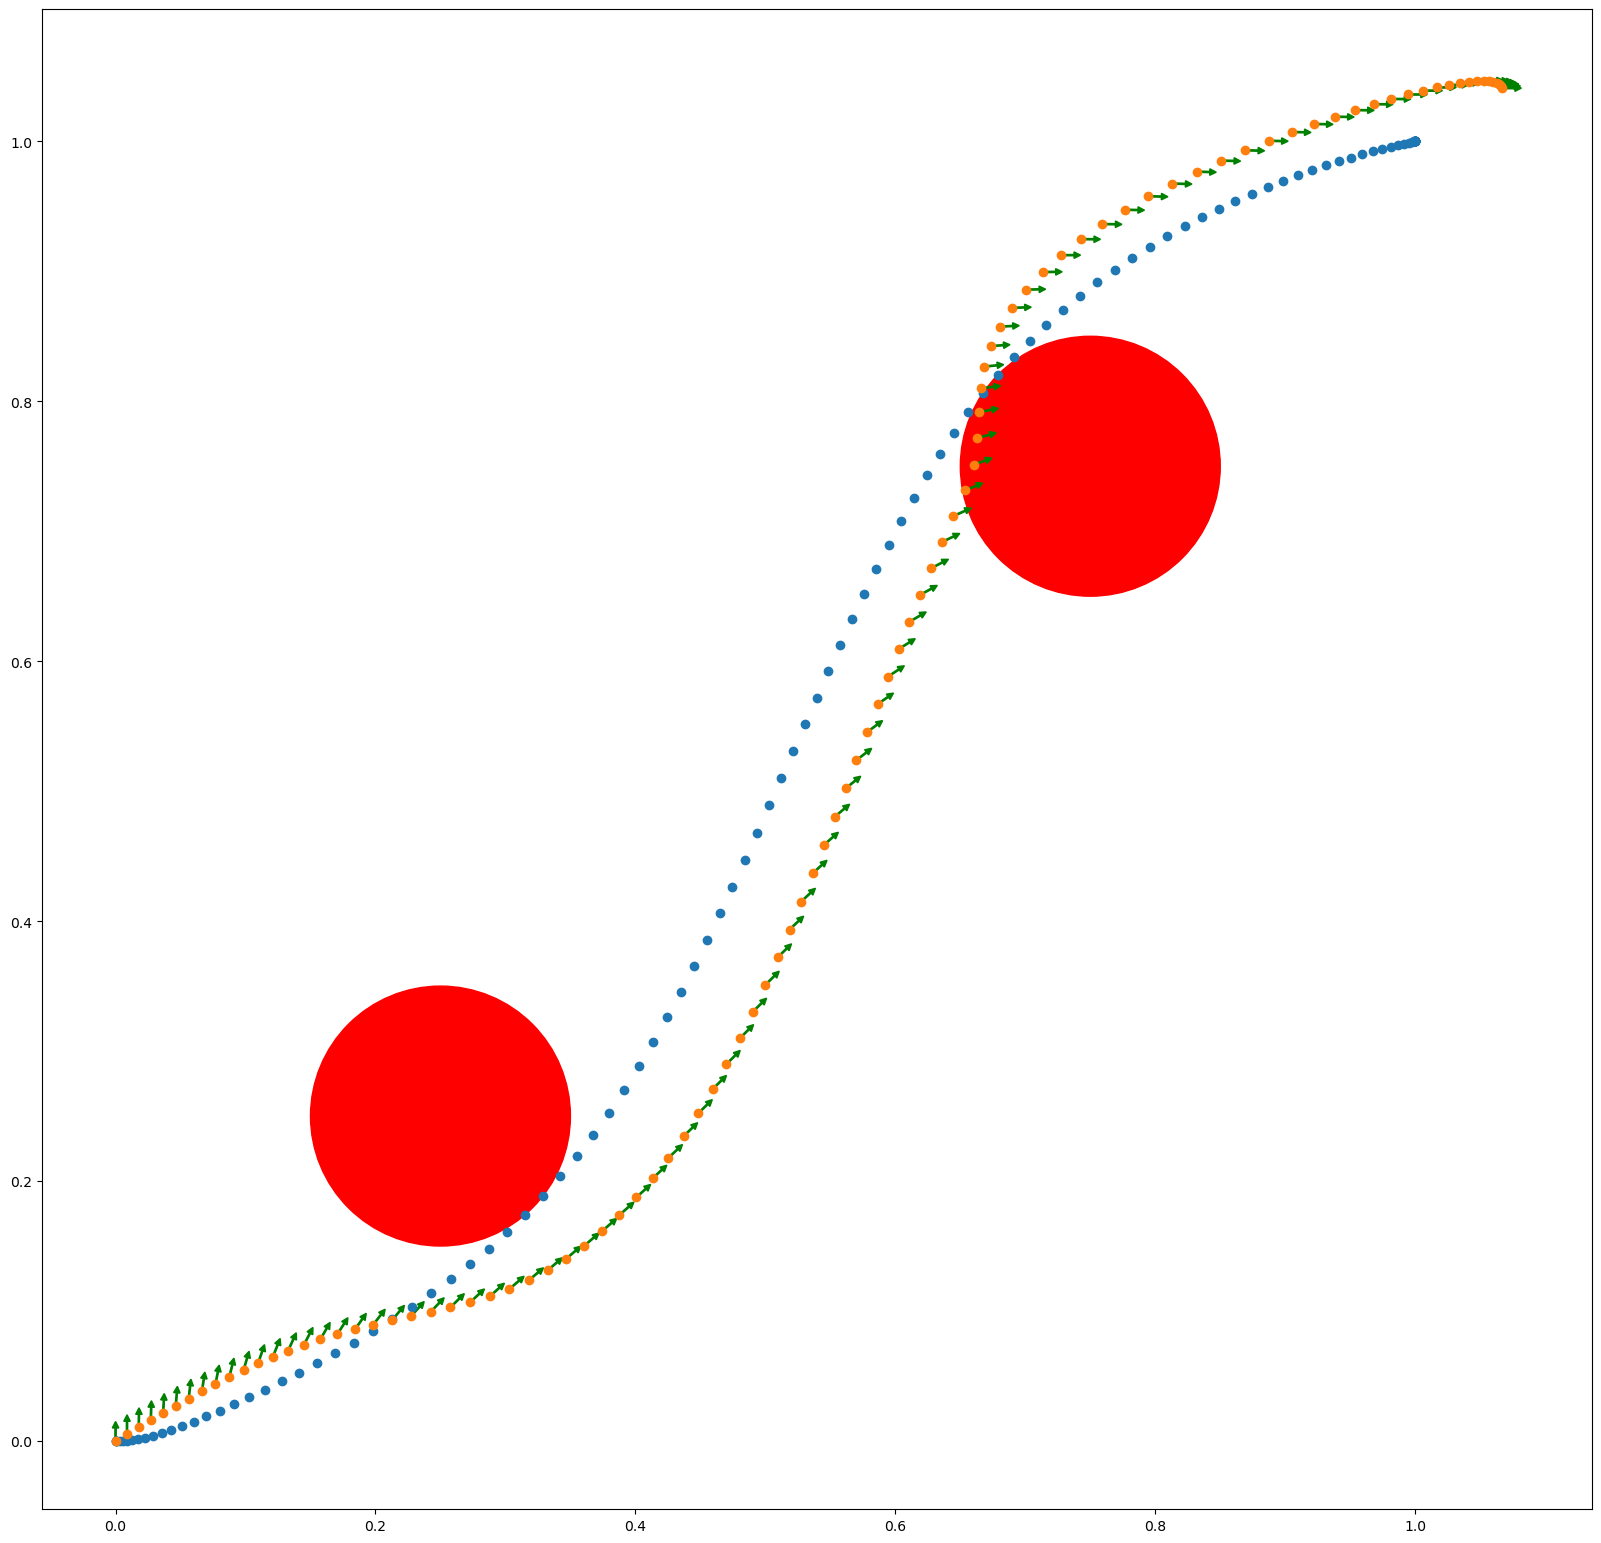

In [4]:
ps = S_soln.T
ps_ref = Sref.T
fig, axes = plt.subplots(1, 1, figsize=(20, 20))

for obstacle in obstacles:
    obs_x, obs_y, obs_r = obstacle
    circle = plt.Circle((obs_y, obs_x), obs_r, color='r')
    axes.add_patch(circle)

for i in range(len(ps[1])):
    dx = 0.01*np.cos(ps[2,i])
    dy = 0.01*np.sin(ps[2,i])
    axes.arrow(ps[1,i], ps[0, i], dy, dx, head_width=0.005, head_length=0.005, fc='green', ec='green')
    
axes.scatter(ps_ref[1], ps_ref[0])
axes.scatter(ps[1], ps[0])
axes.set_aspect('equal', adjustable='box')
plt.show()